## Case study: Data processing in FDDs

## 1. Data Preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 150

In [2]:
# customize the style of dataframes and plots

In [3]:
%%HTML
<style>.dataframe th{
background:#3f577c; 
font-family:monospace; 
color:white; 
border:3px solid white; 
text-align:left !important;}
</style>

In [4]:
%%HTML
<style>.output_png {
display: table-cell;
text-align: center;
vertical-align: middle;}
</style>

In [5]:
os.listdir("./Project Academic_data room/")

['DATA_Cons.xlsx',
 'Destinations.xlsx',
 'DATA_SKU.xlsx',
 'Entities.xlsx',
 'AccountMapping NEW.xlsx',
 'AccountMapping.xlsx']

In [ ]:
# load datasets
acc_mapping = pd.read_excel("./Project Academic_data room/AccountMapping NEW.xlsx")
data_cons = pd.read_excel("./Project Academic_data room/DATA_Cons.xlsx")
data_sku = pd.read_excel("./Project Academic_data room/DATA_SKU.xlsx")
destinations = pd.read_excel("./Project Academic_data room/Destinations.xlsx")
entities = pd.read_excel("./Project Academic_data room/Entities.xlsx")

### 1.1 Preprocessing of DATA_Cons

In [ ]:
# explore the data_cons_pr dataset
data_cons.info()

Columns ProductName and Product contain mostly null values. Those columns are not dropped for it can affect the future analysis. We can also see that the column Amount contains some null values. 

In [ ]:
# check the unique values of the column Scope
print(data_cons["Scope"].unique())

In [ ]:
# copy dataset before preprocessing
data_cons_pr = data_cons.copy()

In [ ]:
# drop columns with NA entries
#data_cons_pr = data_cons_pr.drop(columns=["ProductName", "Product"])

In [ ]:
# find the columns with NAN or NULL 
data_cons_pr.isnull().sum()

In [ ]:
data_cons_pr_null = data_cons_pr[data_cons_pr["Amount"].isnull()]

In [ ]:
# inspect the data for the missing values in the column Amount in order to find any correlations
for i in range (len(data_cons_pr_null.columns)):
    display(data_cons_pr_null.iloc[:,i].value_counts().to_frame())

Most of the NA data belongs to the products with a delivery adress in Paraguay and Uruguay (Local Currency table). In other words, the accounting culture in those countries may lack the rigiriousity. Since missing values are not distributed randomly, the best solution might be to substitute them with the median for the certain scope, year and local currency. We avoid substituting on the level of the same account since some accounts have only few transactions or no transactions at all.

In [ ]:
# create a list of all carveout and out of scope oblects
list_carveout = sorted(data_cons_pr["Scope"].unique().tolist())

In [ ]:
# create a table of medians
loc_cur = data_cons_pr_null["LocalCurrency"].unique().tolist()
group_by_table = data_cons_pr.groupby(by=["LocalCurrency", "Scope", "Year"]).median().loc[:,"Amount"].loc[loc_cur]

In [ ]:
# substitute the missing values with median for the year, scope and local currency
index_list = data_cons_pr_null.index.tolist()
for ind in index_list:
    data_cons_pr.loc[ind, "Amount"] = group_by_table[(data_cons_pr_null.loc[ind,"LocalCurrency"],
                                                    data_cons_pr_null.loc[ind,"Scope"],
                                                    data_cons_pr_null.loc[ind,"Year"])] 

In [ ]:
# check if any NA data remained in the Amount table
data_cons_pr.isnull().sum()

### 1.2 Preprocessing of DATA_sku

In [ ]:
# explore the data_sku_pr dataset
data_sku.info()

In [ ]:
data_sku.isnull().sum()

No missing values in the data

In [ ]:
# check the column "Scope"
print(data_sku["Scope"].unique())

In [ ]:
# copy dataset before preprocessing
data_sku_pr = data_sku.copy()

## 1.3 Preprocessing of Account mapping

The account number is a primary key, therefore it should be check if all account numbers are unique.

In [ ]:
acc_mapping["AccountNumber"].value_counts().loc[lambda x: x > 1]

In [ ]:
# check the rows with those account numbers
acc_mapping[acc_mapping["AccountNumber"].isin([80000210, 80000150])]

These rows are just a duplication, hence row 88 and row 95 can be deleted.

In [ ]:
acc_mapping_pr = acc_mapping.copy()
acc_mapping_pr = acc_mapping_pr.drop([88,95]).reset_index()

## 1.4 Preprocessing of Destinations and Entities

Check if primary keys in entities and destinations are unique

In [ ]:
entities['LegalEntityCode'].value_counts().loc[lambda x: x > 1]

NA (North America) entries should be changed to N.A., otherwise those entries will be counted as null values.

In [ ]:
entities_pr = entities.copy()
entities_pr.loc[entities_pr["Region"].isnull(), "Region"] = "N.A."

In [ ]:
destinations['DeliveryCountryCode'].value_counts().loc[lambda x: x > 1]

In [ ]:
# check the rows with duplicates
destinations[destinations['DeliveryCountryCode']=="KR"]

In [ ]:
# drop duplication
destinations_pr = destinations.copy()
destinations_pr = destinations_pr.drop([77]).reset_index()

Again, NA (North America) entries changed to N.A.

In [ ]:
destinations_pr.loc[destinations_pr["DeliveryRegion"].isnull(), "DeliveryRegion"] = "N.A."

## 2. Data mapping

In [ ]:
# merge acc_mapping with the cons dataset
data_cons_pr_mapped = pd.merge(data_cons_pr, acc_mapping_pr, how='left', 
                               left_on='AccountNumber', right_on='AccountNumber')
data_cons_pr_mapped = data_cons_pr_mapped.drop(columns = ["index"]);

In [ ]:
# merge acc_mapping with the sku dataset
data_sku_pr_mapped = pd.merge(data_sku_pr, acc_mapping_pr, how='left', 
                               left_on='AccountNumber', right_on='AccountNumber')
data_sku_pr_mapped = data_sku_pr_mapped.drop(columns = ["index"]);

In [ ]:
# Merge datasets with entities and destinations
data_cons_pr_mapped = pd.merge(data_cons_pr_mapped, entities_pr, how='left', 
                               left_on='LegalEntityCode', right_on='LegalEntityCode')
data_cons_pr_mapped = pd.merge(data_cons_pr_mapped, destinations_pr, how='left', 
                               left_on='DeliveryCountryCode', right_on='DeliveryCountryCode')
data_cons_pr_mapped = data_cons_pr_mapped.drop(columns = ["index"]);

In [ ]:
data_sku_pr_mapped = pd.merge(data_sku_pr_mapped, entities_pr, how='left', 
                               left_on='LegalEntityCode', right_on='LegalEntityCode')
data_sku_pr_mapped = pd.merge(data_sku_pr_mapped, destinations_pr, how='left', 
                               left_on='DeliveryCountryCode', right_on='DeliveryCountryCode')
data_sku_pr_mapped = data_sku_pr_mapped.drop(columns = ["index"]);

In [ ]:
data_cons_pr_mapped.info()

In [ ]:
data_sku_pr_mapped.info()

Both datasets were fully merged with account mapping.Despite the fact some NA values exist in the columns that correspond to entities and destinations datasets, we can still proceed since they have no affect on P&L statement.

##  3. Data inconsistencies

In [ ]:
data_sku_pr_mapped["BusinessUnit"] = data_sku_pr_mapped["BusinessUnit"].astype('str')

In [ ]:
data_sku_pr_mapped["Product"] = data_sku_pr_mapped["Product"].astype('str')

In [ ]:
data_sku_pr_mapped["Unit_Unitname"] = data_sku_pr_mapped["BusinessUnit"] + "_" + data_sku_pr_mapped["BusinessUnitName"]

In [ ]:
data_sku_pr_mapped["Unit_Unitname"].value_counts()

No inconsistencies in the entries of Business units.

In [ ]:
number_inconsist = 0
for i in range(len(data_sku_pr_mapped)):
    if data_sku_pr_mapped["Product"][i] not in data_sku_pr_mapped["ProductName"][i]:
        number_inconsist += 1
print(f"Number of inconsistent rows: {number_inconsist}")

No inconsistencies in the entries of Products.

Check inconsistencies in Data_Cons.

In [ ]:
data_cons_pr_mapped["BusinessUnit"] = data_cons_pr_mapped["BusinessUnit"].astype('str')

In [ ]:
data_cons_pr_mapped["Unit_Unitname"] = data_cons_pr_mapped["BusinessUnit"] + "_" + data_cons_pr_mapped["BusinessUnitName"]

In [ ]:
data_cons_pr_mapped["Unit_Unitname"].value_counts()

Business Unit 81279 is associated with 2 Business Names. It will not affect the analysis. 

## 4. P&L

<div>
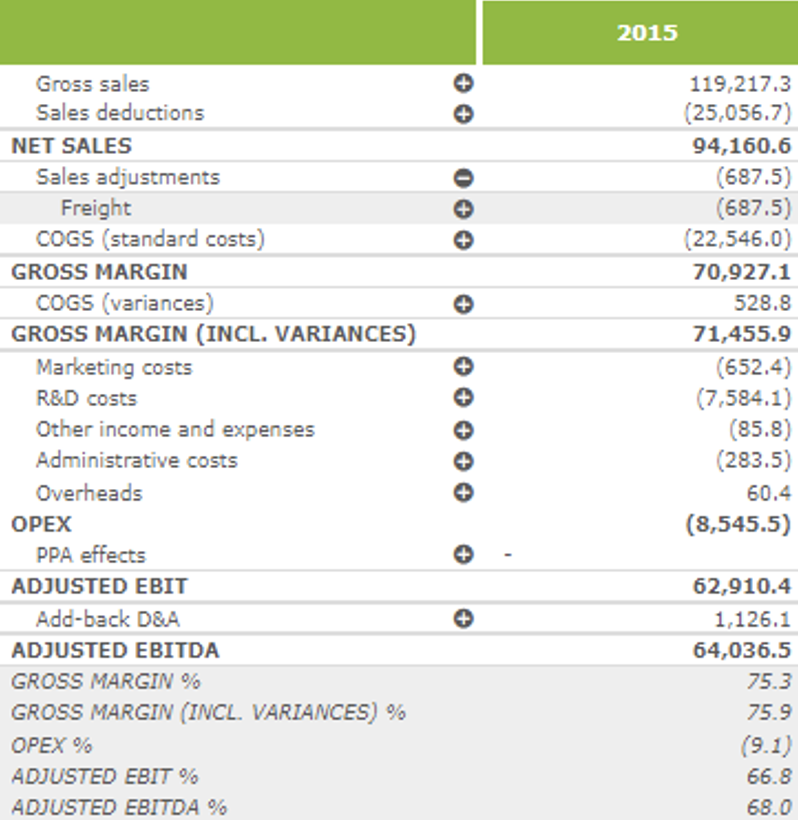
</div>

It is reasonable to use the Alternative Level 2 Name and Alternative Level 3 Name to construct the P&L. We should drop the rows corresponding to Quantities (Level 6 names) as they have no effect on EBITDA.

The structure of P&L will be based on the template provided in the case, therefore PPA effects will not be accounted for OPEX. Special items are included in OPEX.

In [ ]:
# copy before processing
below_margin = data_cons_pr_mapped.copy()
sales_to_margin = data_sku_pr_mapped.copy()

# filter out entries that have no effect on EBITDA
sales_to_margin = sales_to_margin[sales_to_margin.loc[:,'Level 6 Name'] != "Quantities"]

At this step we establish a function that will create P&L statement from below_margin and sales_to_margin dataset based on user preferences (for a particular timespan and particular objects, controlled for particular entities (if needed)). Finction returns both a list of P&Ls for all objects and a merged P&L.

In [ ]:
def p_l_creator(sales_to_marg, below_marg, year_list, object_column, filtering=False,
                entity_column= " ", entity_list=[]):
    
    # list of relevant accounts for each dataset
    # created manually to avoid possible account inconsistencies 
    accounts_sales_to_margin = ["Gross sales", "Sales deductions", "Selling expenses", 
                                "COGS (fixed)", "COGS (variable)"]
    accounts_below_margin = ["COGS (variances)", "Marketing costs", "R&D costs",
                             "Adj. for accounts receivable","Other expenses", "Other income", 
                             "Special items", "Administrative costs", "Manufacturing overheads", 
                   "Other overheads", "PPA effects", "Add-back D&A"]
    
    # filter datasets by relevant accounts
    sales_to_marg = sales_to_marg[sales_to_marg["Alternative Level 3 Name"].isin(accounts_sales_to_margin)]
    below_marg = below_marg[below_marg["Alternative Level 3 Name"].isin(accounts_below_margin)]
    
    if filtering == True:
        sales_to_marg = sales_to_marg[sales_to_marg[entity_column].isin(entity_list)]
        below_marg = below_marg[below_marg[entity_column].isin(entity_list)]
        
    # filter by the year
    sales_to_marg = sales_to_marg[sales_to_marg["Year"].isin(year_list)]
    below_marg = below_marg[below_marg["Year"].isin(year_list)]

    # create crude sales_to_margin P&L
    pl_sales_to_margin = sales_to_marg.pivot_table(values = "Amount",
                                                   columns = "Year",
                                                   index = [object_column, "Alternative Level 3 Name","Alternative Level 2 Name"],
                                                   aggfunc=np.sum,
                                                   fill_value=0)

    # create crude below_margin P&L
    pl_below_margin = below_marg.pivot_table(values = "Amount",
                                             columns = "Year",
                                             index = [object_column, "Alternative Level 3 Name","Alternative Level 2 Name"],
                                             aggfunc=np.sum,
                                             fill_value=0)

    # create lists of indicies for P&L
    # created manually to avoid possible account inconsistencies 

    index_level = ["Gross sales", "Sales deductions", "Selling expenses", "COGS (fixed)", "COGS (variable)", 
                  "COGS (variances)", "Marketing costs", "R&D costs","Adj. for accounts receivable",
               "Other expenses", "Other income", "Administrative costs", "Manufacturing overheads", 
                  "Other overheads", "PPA effects", "Special items", "Add-back D&A"]

    index_level_with_agg = ["Gross sales", "Sales deductions", "Net sales", "Selling expenses", "COGS (fixed)", 
                       "COGS (variable)", "Gross Margin", "COGS (variances)", "Gross Margin (incl. Variances)", 
                       "Marketing costs", "R&D costs", "Adj. for accounts receivable", "Other expenses",
                       "Other income", "Administrative costs", "Manufacturing overheads", "Other overheads", "OPEX",
                       "PPA effects", "Special items", "Adjusted EBIT", "Add-back D&A", "Adjusted EBITDA", "Gross Margin%", 
                       "Gross Margin (incl. Variances)%", "OPEX%", "Adjusted EBIT%", "Adjusted EBITDA%"]


    # create empty list to store dataframes
    pl_sales_to_margin_scope = []
    pl_below_margin_scope = []
    pl_merged_list = []
    pl_merged_reindexed_list = []
    pl_merged_reindexed_new_list = []
    
    #list of all objects
    object_list = sorted(list(set(sales_to_marg[object_column]).intersection(set(below_marg[object_column]))))
    
    for i in range(len(object_list)):
        scope_above = pl_sales_to_margin.loc[object_list[i]]
        pl_sales_to_margin_scope.append(scope_above)
        scope_below = pl_below_margin.loc[object_list[i]]
        pl_below_margin_scope.append(scope_below)

        pl_merged = pd.concat([pl_sales_to_margin_scope[i], pl_below_margin_scope[i]])
        pl_merged_list.append(pl_merged)

        pl_reindexed = pl_merged_list[i].reindex(index_level, level=0)
        pl_merged_reindexed_list.append(pl_reindexed)

        pl_merged_reindexed_list[i].loc[("Net sales", " "), :] = pl_merged_reindexed_list[i].loc["Gross sales" : "Sales deductions"].sum()
        pl_merged_reindexed_list[i].loc[("Gross Margin", " "), :] = pl_merged_reindexed_list[i].loc["Gross sales" : "COGS (variable)"].sum()
        pl_merged_reindexed_list[i].loc[("Gross Margin (incl. Variances)", " "), :] = pl_merged_reindexed_list[i].loc["Gross sales" : "COGS (variances)"].sum()
        pl_merged_reindexed_list[i].loc[("OPEX", " "), :] = pl_merged_reindexed_list[i].loc["Marketing costs" : "Other overheads"].sum()
        pl_merged_reindexed_list[i].loc[("Adjusted EBIT", " "), :] = pl_merged_reindexed_list[i].loc["Gross sales" : "Special items"].sum()
        pl_merged_reindexed_list[i].loc[("Adjusted EBITDA", " "), :] = pl_merged_reindexed_list[i].loc["Gross sales" : "Add-back D&A"].sum()

        pl_merged_reindexed_list[i].loc[("Gross Margin%", " "), :] =  (pl_merged_reindexed_list[i].loc["Gross Margin"] /  pl_merged_reindexed_list[i].loc["Net sales"] * 100).sum()
        pl_merged_reindexed_list[i].loc[("Gross Margin (incl. Variances)%", " "), :] =  (pl_merged_reindexed_list[i].loc["Gross Margin (incl. Variances)"] / pl_merged_reindexed_list[i].loc["Net sales"] * 100).sum()
        pl_merged_reindexed_list[i].loc[("OPEX%", " "), :] =  (pl_merged_reindexed_list[i].loc["OPEX"] /  pl_merged_reindexed_list[i].loc["Net sales"] * 100).sum()
        pl_merged_reindexed_list[i].loc[("Adjusted EBIT%", " "), :] =  (pl_merged_reindexed_list[i].loc["Adjusted EBIT"] /  pl_merged_reindexed_list[i].loc["Net sales"] * 100).sum()
        pl_merged_reindexed_list[i].loc[("Adjusted EBITDA%", " "), :] =  (pl_merged_reindexed_list[i].loc["Adjusted EBITDA"] /  pl_merged_reindexed_list[i].loc["Net sales"] * 100).sum()

        pl_reindexed = pl_merged_reindexed_list[i].reindex(index_level_with_agg, level=0)
        pl_merged_reindexed_new_list.append(pl_reindexed)
        pl_merged_reindexed_new_list[i].index.rename(["Account", "SubAccount"], inplace=True)

        pl_merged_reindexed_new_list[i].columns = pd.MultiIndex.from_product([[object_list[i]], pl_merged_reindexed_new_list[i].columns])
    
    df_merged_all = pd.concat(pl_merged_reindexed_new_list, axis=1).reindex(index_level_with_agg, level=0).fillna(value=0)

    return pl_merged_reindexed_new_list, df_merged_all

Create P&L for Carveout objects

In [ ]:
p_l_list, p_l_merged = p_l_creator(sales_to_margin, below_margin, [2015, 2016, 2017, 2018], "Scope", list_carveout)
p_l_merged

In [ ]:
# save P&L into excel
p_l_merged.to_excel("PL_merged.xlsx")

##  5. EBITDA Margins

Question: What are the respective EBITDA margins? How do they compare to the out-of-scope figures?

In [ ]:
# create a dataframe with EBITDA margins
list_ebitda = []
for i in range(len(list_carveout)):
    val = p_l_list[i].loc['Adjusted EBITDA%'].to_numpy()[0]
    ind = [x[1] for x in p_l_list[i].columns]
    df_ebitda = pd.DataFrame(data={list_carveout[i]: val}, index=ind)
    list_ebitda.append(df_ebitda)
df_ebitda_joined = pd.concat(list_ebitda, axis=1)

In [ ]:
print("\n                           Adjusted EBITDA%")
display(df_ebitda_joined)

For a better representation we plot the respective numbers on the graph.

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Adjusted EBITDA%")
df_ebitda_joined.plot(kind='bar', ax=ax);
ax.legend(bbox_to_anchor=(1.1, 1.05));
ax.set_xlabel("year");
ax.set_ylabel("%");

We can see that Carveout object 2 has the highest EBITDA margins throughout the whole period (from 38,22% in 2015 to 47,31% in 2018), followed by Carveout object 1 (decreasing from 22,48% in 2015 to 13,24% in 2018). EBITDA margings for Carveout object 3 and Out of scope are negative, with an improving situation for Carveout object 3 (from -72,45 % in 2015 to -17,15% in 2018) and volatile numbers fo Out of Scope (min -151,31 % in 2016 and max -55,18% in 2017).

##  6. Normalization adjustments 

### 6.1 €4m for a legal settlement and lawyer’s fees in 2016 for legal entity 686 (in Germany) under other income and expenses

According to PWC (https://viewpoint.pwc.com/dt/us/en/pwc/accounting_guides/carve-out-financial-statements/carve-out-financial-statements/Chapter-5-Income/5-2-Allocation-of-shared.html), "If the specific identification of expenses is not practicable, a reasonable method of allocating expenses to the carve-out business (e.g., incremental or proportional cost allocation) is used. Because the parent costs allocated to the carve-out business are related party transactions, management should include appropriate disclosures."

In our case, it is reasonable to devide the normalization adjustments proportionally to OPEX based on the business structure of the legal entity, for example OPEX for the entity 686 in 2016 is calculated, then EUR4m will be devided respecitevely to the contribution of each scope entity to the whole OPEX. Moreover, the normalization should also effect the "Out of scope" object, otherwise the business structure will not be fully reflected in the adjustments.

However, we should also check the P&L to have a broader picture.

Create P&L statements for a legal entity 686 (for each carveout object) for a year 2016.

In [ ]:
carveout_list_686 = sorted(below_margin[(below_margin["Year"] == 2016) &
            (below_margin["LegalEntityCode"] == 686) & 
            (below_margin["Country"] == "Germany")]["Scope"].unique())

In [ ]:
p_l_list_686,  p_l_686_merged = p_l_creator(sales_to_margin, below_margin, [2016], "Scope", True, "LegalEntityCode", [686])

In [ ]:
# create a dataframe with proportions
list_opex_686 = []
for i in range(len(carveout_list_686)):
    val = p_l_list_686[i].loc['OPEX'].to_numpy()[0]
    ind = [x[1] for x in p_l_list_686[i].columns]
    df_opex_686 = pd.DataFrame(data={carveout_list_686[i]: val}, index=ind)
    list_opex_686.append(df_opex_686)
list_opex_686_joined = pd.concat(list_opex_686, axis=1)
list_proportions_686 = list_opex_686_joined.div(list_opex_686_joined.sum(axis=1), axis=0)
list_proportions_686

We should add an entry for each Carveout object with a corresponding proportional amount.

P&L may be corrected by two ways: directly change the corresponding cell in the database or manually add a new cashflow. For the porpose of accounting consistency the latter approach was chosen as the datasets could be used for future analysis.

In [ ]:
below_margin_norm = below_margin.copy()

In [ ]:
entry_1 = {'AdjustmentType': 'Normalization',
     'AdjustmentName': 'Adjustment 962',
     'BusinessEntity': 733,
     'BusinessEntityName': 'Segment 734',
     'PortfolioAsset': 'Portfolio asset 735',
     'Scope': 'Carveout object 1',
     'BusinessUnit': 81310,
     'BusinessUnitName': 'Business unit 736',
     'ProductGroup': 'Product group 737',
     'ProductName': "NA",
     'DeliveryCountryCode': 'DE',
     'Year': 2016,
     'HalfYear': 2,
     'LocalCurrency': 'EUR',
     'Month': 12,
     'ScopeCountryCode': 'DE',
     'LegalEntityCode': 686,
     'PostingLevel': 88,
     'PostingLevelName': 'Adjustments and Normalizations',
     'Quarter': 4,
     'Amount': 4000 * list_proportions_686["Carveout object 1"].item(),
     'MonthlyQuantityFlag': 'No quantity',
     'QuantityUnit': 'No quantity',
     'AccountNumber': 72237873,
     'AccountName': 'Other operating expenses',
     'Level 2 Name': 'Other income and expenses',
     'Level 3 Name': 'Operating expenses',
     'Level 4 Name': 'Operating expenses',
     'Level 5 Name': 'EBIT',
     'Level 6 Name': 'EBITDA',
     'Alternative Level 2 Name': 'Other operating expenses',
     'Alternative Level 3 Name': 'Other expenses',
     'CountryCode': 'DE',
     'LegalEntityName': 'Entity 686',
     'Country': 'Germany',
     'Region': 'EMEA',
     'Currency': 'EUR',
     'DeliveryCountry': 'Germany',
     'DeliveryRegion': 'EMEA',
     'DeliveryCurrency': 'EUR',
     'Unit_Unitname': '81310_Business unit 736'}
    
entry_2 = {'AdjustmentType': 'Normalization',
     'AdjustmentName': 'Adjustment 962',
     'BusinessEntity': 733,
     'BusinessEntityName': 'Segment 734',
     'PortfolioAsset': 'Portfolio asset 827',
     'Scope': 'Carveout object 2',
     'BusinessUnit': 81310,
     'BusinessUnitName': 'Business unit 736',
     'ProductGroup': 'Product group 737',
     'ProductName': "NA",
     'DeliveryCountryCode': 'DE',
     'Year': 2016,
     'HalfYear': 2,
     'LocalCurrency': 'EUR',
     'Month': 12,
     'ScopeCountryCode': 'DE',
     'LegalEntityCode': 686,
     'PostingLevel': 88,
     'PostingLevelName': 'Adjustments and Normalizations',
     'Quarter': 4,
     'Amount': 4000 * list_proportions_686["Carveout object 2"].item(),
     'MonthlyQuantityFlag': 'No quantity',
     'QuantityUnit': 'No quantity',
     'AccountNumber': 72237873,
     'AccountName': 'Other operating expenses',
     'Level 2 Name': 'Other income and expenses',
     'Level 3 Name': 'Operating expenses',
     'Level 4 Name': 'Operating expenses',
     'Level 5 Name': 'EBIT',
     'Level 6 Name': 'EBITDA',
     'Alternative Level 2 Name': 'Other operating expenses',
     'Alternative Level 3 Name': 'Other expenses',
     'CountryCode': 'DE',
     'LegalEntityName': 'Entity 686',
     'Country': 'Germany',
     'Region': 'EMEA',
     'Currency': 'EUR',
     'DeliveryCountry': 'Germany',
     'DeliveryRegion': 'EMEA',
     'DeliveryCurrency': 'EUR',
     'Unit_Unitname': '81310_Business unit 736'}

entry_3 = {'AdjustmentType': 'Normalization',
     'AdjustmentName': 'Adjustment 873',
     'BusinessEntity': 733,
     'BusinessEntityName': 'Segment 734',
     'PortfolioAsset': 'Portfolio asset 757',
     'Scope': 'Out of scope',
     'BusinessUnit': 81310,
     'BusinessUnitName': 'Business unit 736',
     'ProductGroup': 'Product group 737',
     'ProductName': "NA",
     'DeliveryCountryCode': 'DE',
     'Year': 2016,
     'HalfYear': 2,
     'LocalCurrency': 'EUR',
     'Month': 12,
     'ScopeCountryCode': 'DE',
     'LegalEntityCode': 686,
     'PostingLevel': 88,
     'PostingLevelName': 'Adjustments and Normalizations',
     'Quarter': 4,
     'Amount': 4000 * list_proportions_686["Out of scope"].item(),
     'MonthlyQuantityFlag': 'No quantity',
     'QuantityUnit': 'No quantity',
     'AccountNumber': 72237873,
     'AccountName': 'Other operating expenses',
     'Level 2 Name': 'Other income and expenses',
     'Level 3 Name': 'Operating expenses',
     'Level 4 Name': 'Operating expenses',
     'Level 5 Name': 'EBIT',
     'Level 6 Name': 'EBITDA',
     'Alternative Level 2 Name': 'Other operating expenses',
     'Alternative Level 3 Name': 'Other expenses',
     'CountryCode': 'DE',
     'LegalEntityName': 'Entity 686',
     'Country': 'Germany',
     'Region': 'EMEA',
     'Currency': 'EUR',
     'DeliveryCountry': 'Germany',
     'DeliveryRegion': 'EMEA',
     'DeliveryCurrency': 'EUR',
     'Unit_Unitname': '81310_Business unit 736'}

In [ ]:
below_margin_norm = below_margin_norm.append(entry_1, ignore_index=True)
below_margin_norm = below_margin_norm.append(entry_2, ignore_index=True)
below_margin_norm = below_margin_norm.append(entry_3, ignore_index=True)

### 6.2 Several severance packages for €3m related to the same topic in 2018 for legal entity 730 (in Germany) under other income and expenses

In [ ]:
p_l_list_730,  p_l_730_merged = p_l_creator(sales_to_margin, below_margin, [2018], "Scope", True, "LegalEntityCode", [730])

In [ ]:
p_l_730_merged

In 2018, it was only Out of scope object that affiliated with legal entity 730 and accounted sales deductions.

In [ ]:
below_margin.loc[
                (below_margin["Year"] == 2018) &
                (below_margin["LegalEntityCode"] == 730) & 
                (below_margin["Country"] == "Germany") &
                (below_margin["Alternative Level 3 Name"].isin(["Marketing costs", "R&D costs", 
                "Adj. for accounts receivable", "Other expenses", "Other income", 
                "Administrative costs", "Manufacturing overheads", "Other overheads"])),
                ["Scope","Amount"]].groupby("Scope").sum()

Moreover, only Out of scope object had has legitimate OPEX in connection with legal entity 730. Therefore, severance packages will be accounted under Out of scope.

In [ ]:
entry_4 = {'AdjustmentType': 'Normalization',
     'AdjustmentName': 'Adjustment 873',
     'BusinessEntity': 733,
     'BusinessEntityName': 'Segment 734',
     'PortfolioAsset': 'Portfolio asset 757',
     'Scope': 'Out of scope',
     'BusinessUnit': 81330,
     'BusinessUnitName': 'Business unit 758',
     'ProductGroup': 'Product group 737',
     'ProductName': "NA",
     'DeliveryCountryCode': 'DE',
     'Year': 2018,
     'HalfYear': 2,
     'LocalCurrency': 'EUR',
     'Month': 12,
     'ScopeCountryCode': 'DE',
     'LegalEntityCode': 730,
     'PostingLevel': 88,
     'PostingLevelName': 'Adjustments and Normalizations',
     'Quarter': 4,
     'Amount': 3000,
     'MonthlyQuantityFlag': 'No quantity',
     'QuantityUnit': 'No quantity',
     'AccountNumber': 72237873,
     'AccountName': 'Other operating expenses',
     'Level 2 Name': 'Other income and expenses',
     'Level 3 Name': 'Operating expenses',
     'Level 4 Name': 'Operating expenses',
     'Level 5 Name': 'EBIT',
     'Level 6 Name': 'EBITDA',
     'Alternative Level 2 Name': 'Other operating expenses',
     'Alternative Level 3 Name': 'Other expenses',
     'CountryCode': 'DE',
     'LegalEntityName': 'Entity 686',
     'Country': 'Germany',
     'Region': 'EMEA',
     'Currency': 'EUR',
     'DeliveryCountry': 'Germany',
     'DeliveryRegion': 'EMEA',
     'DeliveryCurrency': 'EUR',
     'Unit_Unitname': '81330_Business unit 758'}

In [ ]:
below_margin_norm = below_margin_norm.append(entry_4, ignore_index=True)

### 6.3 Research costs of €1.2m in 2015+2016 and €0.5m in 2017 for legal entity 692 (in Canada); as research for the products within the carve-out scope has concluded, these costs are unlikely to re-appear 

In [ ]:
p_l_list_692,  p_l_692_merged = p_l_creator(sales_to_margin, below_margin, [2015, 2016, 2017], "Scope", True, "LegalEntityCode", [692])

In [ ]:
p_l_692_merged

In [ ]:
below_margin.loc[
                (below_margin["Year"].isin([2015,2016,2017])) &
                (below_margin["LegalEntityCode"] == 692) & 
                (below_margin["Country"] == "Canada") &
                (below_margin["Alternative Level 3 Name"].isin(["Marketing costs", "R&D costs", 
                "Adj. for accounts receivable", "Other expenses", "Other income", 
                "Administrative costs", "Manufacturing overheads", "Other overheads"])),
                ["Scope","Amount","Year"]].groupby(["Scope", "Year"]).sum()

It makes sence to account research costs exclusively under Carveout 2 since only this object has substantil sales and OPEX in affiliation with legal entity 692.

In [ ]:
entry_5 = {'AdjustmentType': 'Normalization',
     'AdjustmentName': 'Adjustment 962',
     'BusinessEntity': 733,
     'BusinessEntityName': 'Segment 734',
     'PortfolioAsset': 'Portfolio asset 888',
     'Scope': 'Carveout object 2',
     'BusinessUnit': 81310,
     'BusinessUnitName': 'Business unit 736',
     'ProductGroup': 'Product group 737',
     'ProductName': "NA",
     'DeliveryCountryCode': 'CA',
     'Year': 2015,
     'HalfYear': 2,
     'LocalCurrency': 'CAD',
     'Month': 12,
     'ScopeCountryCode': 'CA',
     'LegalEntityCode': 692,
     'PostingLevel': 88,
     'PostingLevelName': 'Adjustments and Normalizations',
     'Quarter': 4,
     'Amount': 1200,
     'MonthlyQuantityFlag': 'No quantity',
     'QuantityUnit': 'No quantity',
     'AccountNumber': 70213473,
     'AccountName': 'R&D costs (group allocations)',
     'Level 2 Name': 'R&D costs',
     'Level 3 Name': 'Operating expenses',
     'Level 4 Name': 'Operating expenses',
     'Level 5 Name': 'EBIT',
     'Level 6 Name': 'EBITDA',
     'Alternative Level 2 Name': 'R&D costs (group allocations)',
     'Alternative Level 3 Name': 'R&D costs',
     'CountryCode': 'CA',
     'LegalEntityName': 'Entity 692',
     'Country': 'Canada',
     'Region': 'N.A.',
     'Currency': 'CAD',
     'DeliveryCountry': 'Canada',
     'DeliveryRegion': 'N.A.',
     'DeliveryCurrency': 'CAD',
     'Unit_Unitname': '81310_Business unit 736'}

entry_6 = {'AdjustmentType': 'Normalization',
     'AdjustmentName': 'Adjustment 962',
     'BusinessEntity': 733,
     'BusinessEntityName': 'Segment 734',
     'PortfolioAsset': 'Portfolio asset 888',
     'Scope': 'Carveout object 2',
     'BusinessUnit': 81310,
     'BusinessUnitName': 'Business unit 736',
     'ProductGroup': 'Product group 737',
     'ProductName': "NA",
     'DeliveryCountryCode': 'CA',
     'Year': 2016,
     'HalfYear': 2,
     'LocalCurrency': 'CAD',
     'Month': 12,
     'ScopeCountryCode': 'CA',
     'LegalEntityCode': 692,
     'PostingLevel': 88,
     'PostingLevelName': 'Adjustments and Normalizations',
     'Quarter': 4,
     'Amount': 1200,
     'MonthlyQuantityFlag': 'No quantity',
     'QuantityUnit': 'No quantity',
     'AccountNumber': 70213473,
     'AccountName': 'R&D costs (group allocations)',
     'Level 2 Name': 'R&D costs',
     'Level 3 Name': 'Operating expenses',
     'Level 4 Name': 'Operating expenses',
     'Level 5 Name': 'EBIT',
     'Level 6 Name': 'EBITDA',
     'Alternative Level 2 Name': 'R&D costs (group allocations)',
     'Alternative Level 3 Name': 'R&D costs',
     'CountryCode': 'CA',
     'LegalEntityName': 'Entity 692',
     'Country': 'Canada',
     'Region': 'N.A.',
     'Currency': 'CAD',
     'DeliveryCountry': 'Canada',
     'DeliveryRegion': 'N.A.',
     'DeliveryCurrency': 'CAD',
     'Unit_Unitname': '81310_Business unit 736'}

entry_7 = {'AdjustmentType': 'Normalization',
     'AdjustmentName': 'Adjustment 962',
     'BusinessEntity': 733,
     'BusinessEntityName': 'Segment 734',
     'PortfolioAsset': 'Portfolio asset 888',
     'Scope': 'Carveout object 2',
     'BusinessUnit': 81310,
     'BusinessUnitName': 'Business unit 736',
     'ProductGroup': 'Product group 737',
     'ProductName': "NA",
     'DeliveryCountryCode': 'CA',
     'Year': 2017,
     'HalfYear': 2,
     'LocalCurrency': 'CAD',
     'Month': 12,
     'ScopeCountryCode': 'CA',
     'LegalEntityCode': 692,
     'PostingLevel': 88,
     'PostingLevelName': 'Adjustments and Normalizations',
     'Quarter': 4,
     'Amount': 500,
     'MonthlyQuantityFlag': 'No quantity',
     'QuantityUnit': 'No quantity',
     'AccountNumber': 70213473,
     'AccountName': 'R&D costs (group allocations)',
     'Level 2 Name': 'R&D costs',
     'Level 3 Name': 'Operating expenses',
     'Level 4 Name': 'Operating expenses',
     'Level 5 Name': 'EBIT',
     'Level 6 Name': 'EBITDA',
     'Alternative Level 2 Name': 'R&D costs (group allocations)',
     'Alternative Level 3 Name': 'R&D costs',
     'CountryCode': 'CA',
     'LegalEntityName': 'Entity 692',
     'Country': 'Canada',
     'Region': 'N.A.',
     'Currency': 'CAD',
     'DeliveryCountry': 'Canada',
     'DeliveryRegion': 'N.A.',
     'DeliveryCurrency': 'CAD',
     'Unit_Unitname': '81310_Business unit 736'}

In [ ]:
below_margin_norm = below_margin_norm.append(entry_5, ignore_index=True)
below_margin_norm = below_margin_norm.append(entry_6, ignore_index=True)
below_margin_norm = below_margin_norm.append(entry_7, ignore_index=True)

In [ ]:
p_l_list_norm, p_l_merged_norm = p_l_creator(sales_to_margin, below_margin_norm, [2015, 2016, 2017, 2018], "Scope")

In [ ]:
# save normalized P&L into excel
p_l_merged_norm.to_excel("PL_merged_norm.xlsx")

Comparison of Adjusted EBITDA% for both P&Ls.

In [ ]:
list_ebitda_norm = []
for i in range(len(list_carveout)):
    val = p_l_list_norm[i].loc['Adjusted EBITDA%'].to_numpy()[0]
    ind = [x[1] for x in p_l_list_norm[i].columns]
    df_ebitda_norm = pd.DataFrame(data={list_carveout[i]: val}, index=ind)
    list_ebitda_norm.append(df_ebitda_norm)
df_ebitda_norm_joined = pd.concat(list_ebitda_norm, axis=1)
df_ebitda_norm_joined = df_ebitda_norm_joined.rename(columns={"Carveout object 1": "Carveout object 1 norm.", 
                                      "Carveout object 2": "Carveout object 2 norm.",
                                      "Carveout object 3": "Carveout object 3 norm.",
                                      "Out of scope": "Out of scope norm."})

In [ ]:
print("\n                           Adjusted EBITDA(normalized)%")
display(df_ebitda_norm_joined)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Adjusted EBITDA% comparison")
df_ebitda_norm_joined.plot(ax=ax,style = '-.');
df_ebitda_joined.plot(ax=ax);
ax.legend(bbox_to_anchor=(1.1, 1.05));
ax.set_xlabel("year");
ax.set_ylabel("%");
ax.set_xlim(2015,2018);
ax.set_xticks([2015,2016,2017,2018]);

Adjusted EBITDA changed significantly only for Out of scope object for the year 2016 and 2018.

## 7. Top line analysis

Question: Identify drivers of net sales and gross margin growth. Which products and which delivery countries are main contributors? Which products and countries are underperforming?

## 7.1 Delivery countries 

Create the tables with total Net sale on the Year and the Year/Delivery Country level.

In [ ]:
net_sales_year = sales_to_margin.loc[sales_to_margin["Alternative Level 3 Name"].isin(
    ["Gross sales", "Sales deductions"]),
    ["Year", "Amount"]].groupby(["Year"]).sum()

net_sales_country_year = sales_to_margin.loc[sales_to_margin["Alternative Level 3 Name"].isin(
    ["Gross sales", "Sales deductions"]),["DeliveryCountryCode", "Year", "Amount"]].groupby(
    ["DeliveryCountryCode", "Year"]).sum().rename(columns={"Amount": "Net Sales"})

Create the table with Net Sales as a percentage of Total for each Country.

In [ ]:
net_sales_country_year_percent = net_sales_country_year.copy()

In [ ]:
idx = pd.IndexSlice
list_empty = []
for i in [2015, 2016, 2017, 2018]:
    net_sales_country_year_percent.loc[idx[:, i], :] = net_sales_country_year.loc[idx[:, i], :].apply( \
        lambda y: y / net_sales_year.loc[i][0] * 100)

In [ ]:
# rename columns
net_sales_country_year_percent.rename(columns={"Net Sales": "Net Sales %"}, inplace=True)

In [ ]:
# merge tables
net_sales_country_year_merged = pd.concat([net_sales_country_year, net_sales_country_year_percent], axis=1)

Create the tables with total Growth margin on the Year and the Year/Delivery Country level.

In [ ]:
growth_margin_year = sales_to_margin.loc[
    sales_to_margin["Alternative Level 3 Name"].isin(["Gross sales", "Sales deductions",\
                                                    "Net sales", "Selling expenses", "COGS (fixed)", \
                                                    "COGS (variable)"]),["Year", "Amount"]].groupby(["Year"]).sum()

growth_margin_country_year = sales_to_margin.loc[
    sales_to_margin["Alternative Level 3 Name"].isin(["Gross sales", "Sales deductions",\
                                                    "Net sales", "Selling expenses", "COGS (fixed)", \
                                                    "COGS (variable)"]),
    ["DeliveryCountryCode", "Year", "Amount"]].groupby(["DeliveryCountryCode", "Year"]).sum().rename(\
                                                    columns={"Amount": "Growth Margin"})

Create the table with Growth margin as a percentage of Total for each country.

In [ ]:
growth_margin_country_year_percent = growth_margin_country_year.copy()

In [ ]:
list_empty = []
for i in [2015, 2016, 2017, 2018]:
    growth_margin_country_year_percent.loc[idx[:, i], :] = growth_margin_country_year.loc[idx[:, i], :].apply(\
        lambda y: y / growth_margin_year.loc[i][0] * 100)

In [ ]:
# rename columns
growth_margin_country_year_percent.rename(columns={"Growth Margin": "Growth Margin %"}, inplace=True)

In [ ]:
# merge tables
growth_margin_merged = pd.concat([growth_margin_country_year, growth_margin_country_year_percent], axis=1)

In [ ]:
# merge Net sales and Growth margin
all_country_year_merged = pd.concat([net_sales_country_year_merged, growth_margin_merged], axis=1)

Performers and underperformers are choosen among top countries ranged by Net Sales % and Growth Margin % in 2018. The contibution of other contries is subtle, and the increase/decrease of the share in the Total sales and Growth margin might be caused by many factors that affect sales but cannot be controlled. In our case, 15 top contries are chosen.

In [ ]:
net_sales_country_year_merged.loc[idx[:, 2018], :].nlargest(15, "Net Sales %")

In [ ]:
growth_margin_merged.loc[idx[:, 2018], :].nlargest(15, "Growth Margin %")

Top countries by 2 factors has a perfect intersection (not a suprise since Groth Margin is a derivative of Net Sales), therefore we can use all 15 countries in our analysis.

In [ ]:
# create a list of top countries
list_of_top_delivery_countries = growth_margin_merged.loc[idx[:, 2018], :].nlargest(\
    15, "Growth Margin %").index.get_level_values(0)

In [ ]:
# filter dataset by the list 
country_top = all_country_year_merged[all_country_year_merged.index.isin(list_of_top_delivery_countries, level=0)]
country_top

It is reasonable to detect best performers/underperformers by a manual analysis of the values, namely: 1) did absolute figures increase consistently, stay on the plateau or decrease? 2) did the share increase/stay on the plateu/decrease? Those countries that remain on the same level are not included in the list of top performers/underperformers.

In [ ]:
# best performers/underperformers identified
best_performers_list = ["CA", "DK", "LT", "MX", "RU", "TR"]
underperformers_list = ["BR", "DE", "GR", "HU", "PH",]

In [ ]:
# create a dataset of best and underperformers
best_performers = country_top[country_top.index.isin(best_performers_list, level=0)]
underperformers = country_top[country_top.index.isin(underperformers_list, level=0)]

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 12), dpi= 80)
fig.suptitle('Best performers/Country')
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xlim(2015,2018)
        ax[i,j].set_xticks([2015,2016,2017,2018])
best_performers.reset_index().pivot('Year','DeliveryCountryCode','Net Sales').plot(ax=ax[0,0], title='Net Sales', grid=True)
best_performers.reset_index().pivot('Year','DeliveryCountryCode','Net Sales %').plot(ax=ax[0,1], title='Net Sales %', grid=True)
best_performers.reset_index().pivot('Year','DeliveryCountryCode','Growth Margin').plot(ax=ax[1,0], title='Growth Margin', grid=True)
best_performers.reset_index().pivot('Year','DeliveryCountryCode','Growth Margin %').plot(ax=ax[1,1], title='Growth Margin %', grid=True)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 12), dpi= 80)
fig.suptitle('Underperformers/Country')
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xlim(2015,2018)
        ax[i,j].set_xticks([2015,2016,2017,2018])
underperformers.reset_index().pivot('Year','DeliveryCountryCode','Net Sales').plot(ax=ax[0,0], title='Net Sales', grid=True)
underperformers.reset_index().pivot('Year','DeliveryCountryCode','Net Sales %').plot(ax=ax[0,1], title='Net Sales %', grid=True)
underperformers.reset_index().pivot('Year','DeliveryCountryCode','Growth Margin').plot(ax=ax[1,0], title='Growth Margin', grid=True)
underperformers.reset_index().pivot('Year','DeliveryCountryCode','Growth Margin %').plot(ax=ax[1,1], title='Growth Margin %', grid=True)
plt.show()

## 7.2 Products

The same approach is used for the product performance analysis.

Create the tables with total Net sale on the Year and the Year/Product level.

In [ ]:
net_sales_product_year = sales_to_margin.loc[sales_to_margin["Alternative Level 3 Name"].isin(
    ["Gross sales", "Sales deductions"]),
    ["ProductName", "Year", "Amount"]].groupby(
    ["ProductName", "Year"]).sum().rename(columns={"Amount": "Net Sales"})

Create the table with Net Sales as a percentage of Total for each Product.

In [ ]:
net_sales_product_year_percent = net_sales_product_year.copy()

In [ ]:
idx = pd.IndexSlice
list_empty = []
for i in [2015, 2016, 2017, 2018]:
    net_sales_product_year_percent.loc[idx[:, i], :] = net_sales_product_year.loc[idx[:, i], :].apply(\
        lambda y: y / net_sales_year.loc[i][0] * 100)

In [ ]:
net_sales_product_year_percent.rename(columns={"Net Sales": "Net Sales %"}, inplace=True)

In [ ]:
# merge tables
net_sales_product_year_merged = pd.concat([net_sales_product_year, net_sales_product_year_percent], axis=1)

Create the table with total Growth margin on the Year/Product level.

In [ ]:
growth_margin_product_year = sales_to_margin.loc[
    sales_to_margin["Alternative Level 3 Name"].isin(["Gross sales", "Sales deductions",\
                                                    "Net sales", "Selling expenses", "COGS (fixed)", \
                                                    "COGS (variable)"]),["ProductName", "Year", "Amount"]].groupby(\
                                                    ["ProductName", "Year"]).sum().rename(columns={"Amount": "Growth Margin"})

Create the table with Growth margin as a percentage of Total for product.

In [ ]:
growth_margin_product_year_percent = growth_margin_product_year.copy()

In [ ]:
list_empty = []
for i in [2015, 2016, 2017, 2018]:
    growth_margin_product_year_percent.loc[idx[:, i], :] = growth_margin_product_year.loc[idx[:, i], :].apply(lambda y: y / growth_margin_year.loc[i][0] * 100)

In [ ]:
growth_margin_product_year_percent.rename(columns={"Growth Margin": "Growth Margin %"}, inplace=True)

In [ ]:
# merge datasets
growth_margin_product_merged = pd.concat([growth_margin_product_year, growth_margin_product_year_percent], axis=1)

In [ ]:
# merge Net sales and Growth margin
all_product_year_merged = pd.concat([net_sales_product_year_merged, growth_margin_product_merged], axis=1)

NAN can occur as not all products have relevant transactions to calculate Net Sales. Also, not every Product was traded during the whole timespan 2015-2018.

Here, 20 top contries are chosen as the average Sales share of a product is less then of a country.

In [ ]:
net_sales_product_year_merged.loc[idx[:, 2018], :].nlargest(20, "Net Sales %")

In [ ]:
growth_margin_product_merged.loc[idx[:, 2018], :].nlargest(20, "Growth Margin %")

In [ ]:
# create a list of intersections among two filtered datasets
list1= net_sales_product_year_merged.loc[idx[:, 2018], :].nlargest(20, "Net Sales %").index.get_level_values(0)
list2= growth_margin_product_merged.loc[idx[:, 2018], :].nlargest(20, "Growth Margin %").index.get_level_values(0)
list_top_products = list(set(list1).intersection(list2))

In [ ]:
# filter dataset by list of top products
top_products = all_product_year_merged[all_product_year_merged.index.isin(list_top_products, level=0)]
top_products

In [ ]:
# define best and underperformers
best_performers_products = ["Product 2473", "Product 3173", "Product 3179", "Product 3244", "Product 3648", "Product 3650", "Product 5115"]
underperformers_products = ["Product 1188", "Product 3153", "Product 3160"]

In [ ]:
# create dataset of best and underperformers
best_performers_products = top_products[top_products.index.isin(best_performers_products, level=0)]
underperformers_products = top_products[top_products.index.isin(underperformers_products, level=0)]

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 12), dpi= 80)
fig.suptitle('Best performers/Product')
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xlim(2015,2018)
        ax[i,j].set_xticks([2015,2016,2017,2018])
best_performers_products.reset_index().pivot('Year','ProductName','Net Sales').plot(ax=ax[0,0], title='Net Sales', grid=True)
best_performers_products.reset_index().pivot('Year','ProductName','Net Sales %').plot(ax=ax[0,1], title='Net Sales %', grid=True)
best_performers_products.reset_index().pivot('Year','ProductName','Growth Margin').plot(ax=ax[1,0], title='Growth Margin', grid=True)
best_performers_products.reset_index().pivot('Year','ProductName','Growth Margin %').plot(ax=ax[1,1], title='Growth Margin %', grid=True)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 12), dpi= 80)
fig.suptitle('Underperformers/Product')
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xlim(2015,2018)
        ax[i,j].set_xticks([2015,2016,2017,2018])
underperformers_products.reset_index().pivot('Year','ProductName','Net Sales').plot(ax=ax[0,0], title='Net Sales', grid=True)
underperformers_products.reset_index().pivot('Year','ProductName','Net Sales %').plot(ax=ax[0,1], title='Net Sales %', grid=True)
underperformers_products.reset_index().pivot('Year','ProductName','Growth Margin').plot(ax=ax[1,0], title='Growth Margin', grid=True)
underperformers_products.reset_index().pivot('Year','ProductName','Growth Margin %').plot(ax=ax[1,1], title='Growth Margin %', grid=True)
plt.show()